In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Import and merge dictionaries of results

In [2]:
import pickle 

def save_dictionary(dict_, FILE_PATH):
    with open(FILE_PATH, 'wb') as f:
        pickle.dump(dict_, f)

def load_dictionary(FILE_PATH):
    with open(FILE_PATH, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

In [5]:
from glob import glob
dict_paths = glob('./dicts/*')
all_dicts = [load_dictionary(path) for path in dict_paths]

dict_ssp_paths = glob('./dicts_ssp/*')
all_dicts += [load_dictionary(path) for path in dict_ssp_paths]

In [7]:
def merge_dicts(dicts):
    merged = {}
    for dic in dicts:
        for key in dic.keys():
            if merged.get(key) is None:
                merged[key] = dic[key]
            else:
                merged[key] += dic[key]
    return merged

In [8]:
dict_results = merge_dicts(all_dicts)

## Histograms

In [119]:
def values_from_key(key):
    key = key.replace(" ", "")
    key = key.split(',')
    Ry = float(key[0])
    s = int(key[1])
    return Ry, s

def get_last_qs(key, dict_results=dict_results):
    res = dict_results[key]
    qs = []
    for r in res:
        params, beta = r
        qs.append(params['q'][-1])
    return qs

def get_Q_matrix(key, dict_results=dict_results):
    res = dict_results[key]
    all_qs = []
    for r in res:
        params, beta = r
        all_qs.append(params['q'])
    return np.array(all_qs)

def get_median_qs(key, dict_results=dict_results):
    Q_matrix = get_Q_matrix(key, dict_results)
    return np.median(Q_matrix, axis=1)

def get_qs_random(key, dict_results=dict_results):
    res = dict_results[key]
    index = np.random.choice(range(len(res)))
    params, beta = res[index]
    return params['q']

In [123]:
def plot_histograms(method, title, bins=None):
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    for i, key in enumerate(dict_results.keys()):
        Ry, s = values_from_key(key)
        qs = method(key)
        if bins is None:
            bins = int(1 + np.log2(len(qs)))
            
        axs[i//3][i%3].hist(qs, bins=bins, color='#86bf91', edgecolor='black', alpha=0.7, density=True, label="histogram")
        axs[i//3][i%3].set_xlim([-0.1, 1.1])
        #axs[i//3][i%3].set_ylim([0, 1.1])
        axs[i//3][i%3].grid(axis='y', linestyle='--', alpha=0.7)
        
#         if legend is not None:
#             posterior_final_median = round(np.median(get_last_qs(key)), 3)
#             legend_proxy = mpatches.Rectangle((0, 0), 1, 1, facecolor="white", edgecolor="white", alpha=0)
#             axs[i//3][i%3].legend([legend_proxy], [f"Median of medians={posterior_final_median}"], 
#                                   bbox_to_anchor=(0.5, 1.2), loc='upper center', fontsize=15)

        # Use gaussian_kde to estimate the kernel density
        kde = gaussian_kde(qs)
        x_values = np.linspace(np.min(qs), np.max(qs), 1000)
        axs[i//3][i%3].plot(x_values, kde(x_values), color='blue', label='KDE')

        if i // 3 == 0:
            axs[i//3][i%3].set_title(f"s = {s}\n", fontsize=18)
        if i % 3 == 0:
            axs[i//3][i%3].set_ylabel(f"Ry = {Ry}", rotation=0, ha='right', fontsize=18)
            
    handles, labels = axs[0][0].get_legend_handles_labels()
    legend_properties = {'weight': 'bold', 'size': 'large'}
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
           fancybox=True, shadow=True, ncol=3, prop=legend_properties)

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.05)

     # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

    ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
    ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

    for y in ys:
        line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
        fig.add_artist(line)

    plt.show()

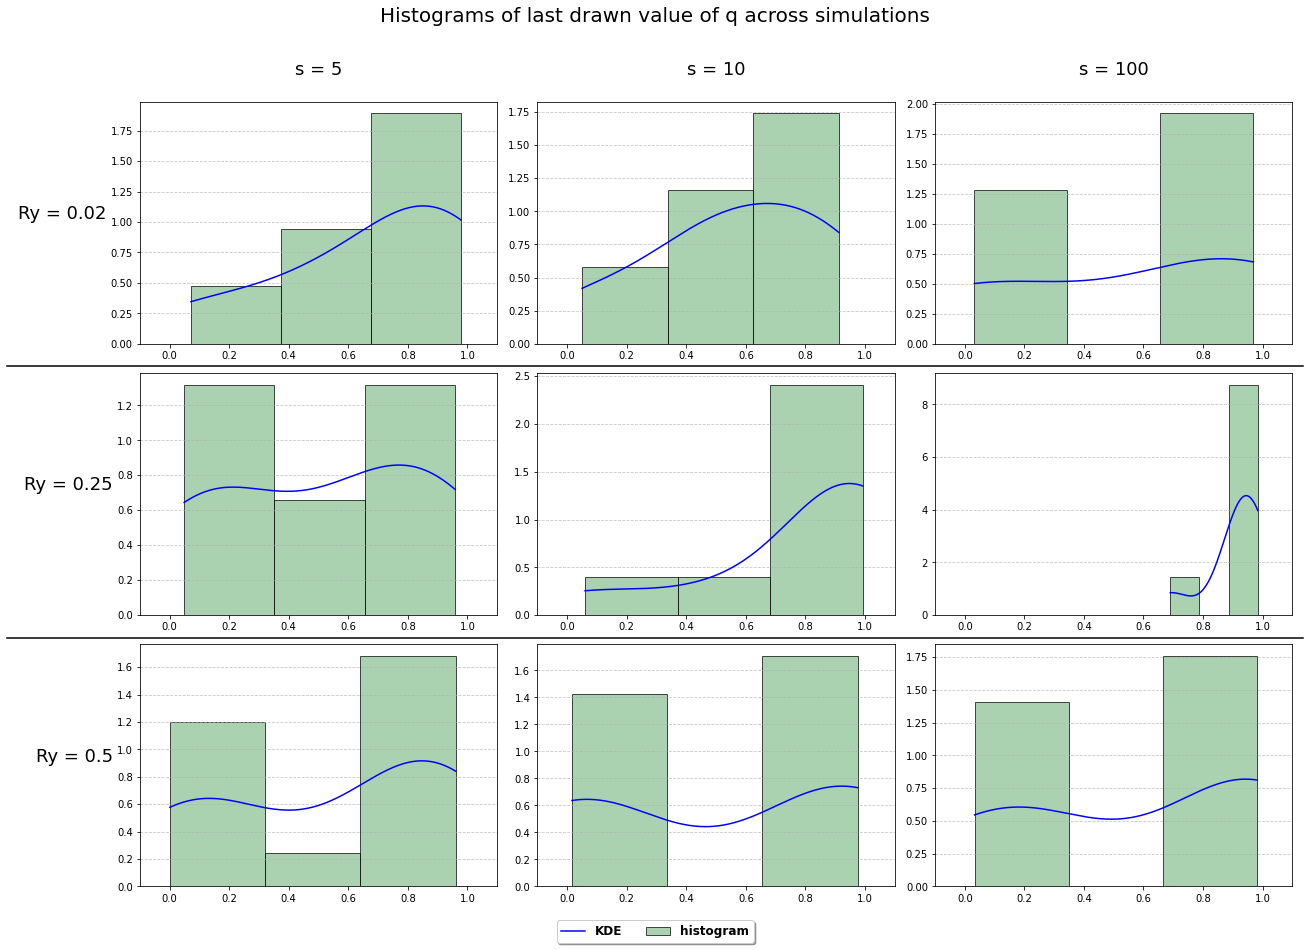

In [124]:
plot_histograms(get_last_qs, "Histograms of last drawn value of q across simulations")

### Q) 2.(a)
For each data set, compute the posterior median of q and plot an histogram (or kernel) approximation of the distribution of the posterior median of q across the 100 data sets.

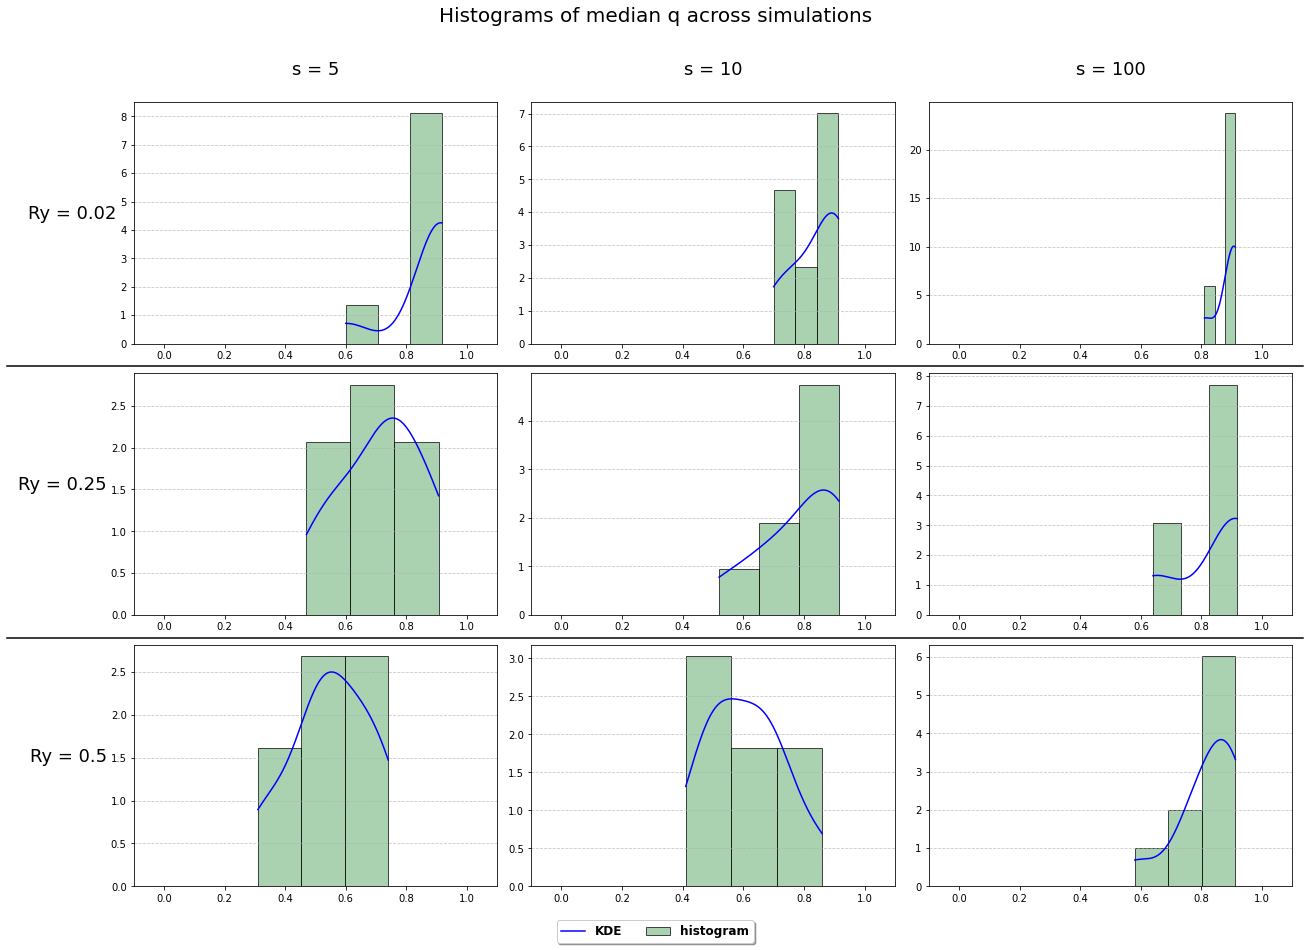

In [125]:
plot_histograms(get_median_qs, "Histograms of median q across simulations")

### Q) 2.(b)
For one data set, plot the marginal posterior distribution of q

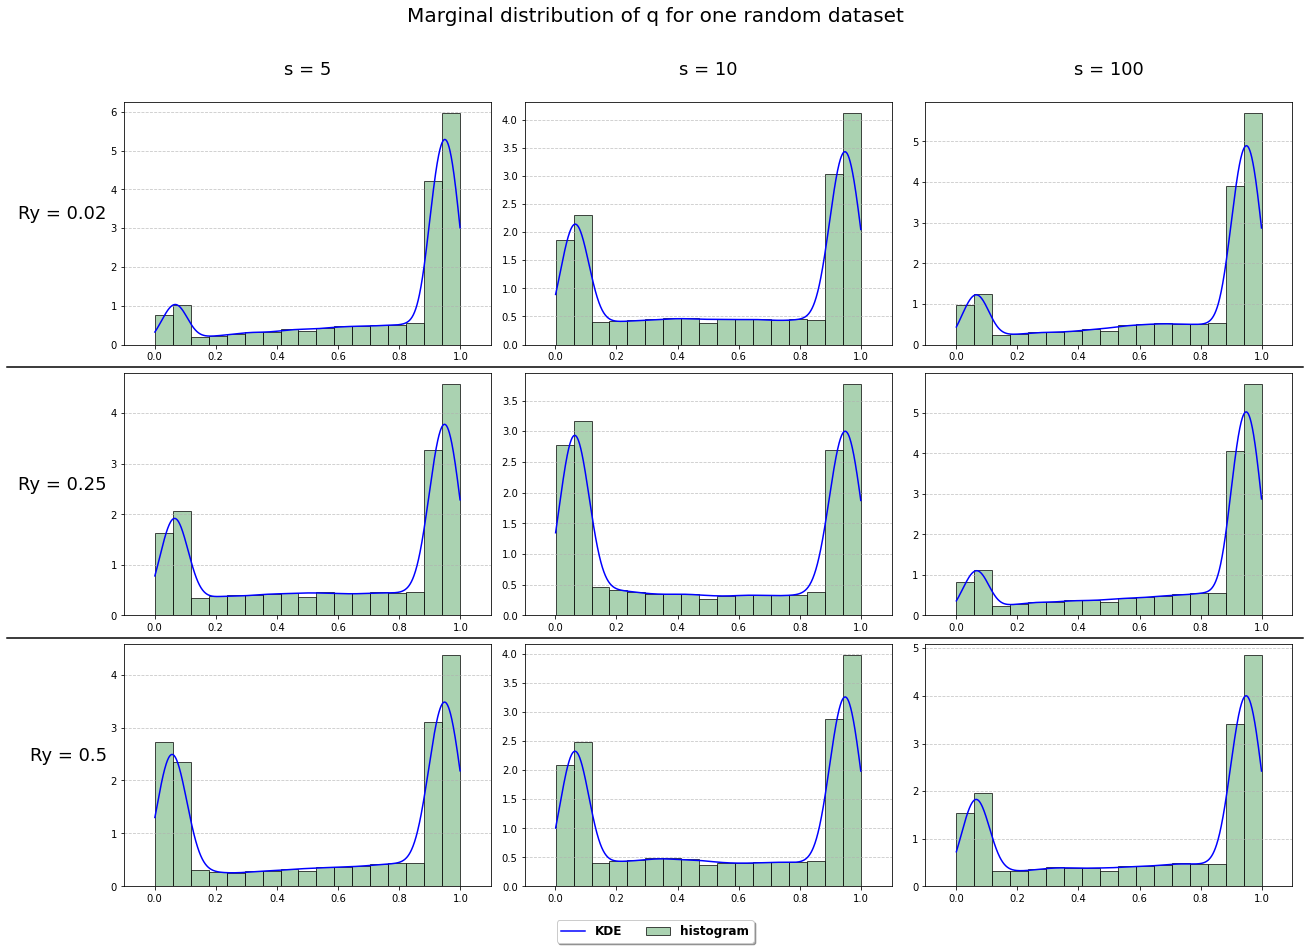

In [126]:
plot_histograms(get_qs_random, "Marginal distribution of q for one random dataset")